## **Optimization Of Self-driving Car Based On Velocity Adjustment in Reinforcement Learning**
MIT License

Copyright (c) [2020] [Cao Bo & Yixuan Wang & Qianjin Wu & Haoyu Yin]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
</br>
</br>

### **Project Goal**


Self driving cars are quite popular these days and a higher level of automation in terms of driving has the potential to reduce dangerous drivers ​behaviors, which may improve road safety and pedestrian safety. Therefore, we think it would be an important and interesting topic to do research on.
</br>
</br>
Our setup is: the agent is driving on a straight road, while several ​pedestrians are standing on the pavement and there are multiple traffic signs and traffic lights along the way.
</br>
</br>
Our goal is to train the agent such that it slows down when approaching the pedestrians and follows all the traffic rules. In addition, our agent still has a certain velocity when it reaches the destination

</br>
</br>

### **Reinforcement Learning Implementation**
Reinforcement learning is considered a powerful AI paradigm that can teach machines by interacting with the environment and learning from mistakes. Despite its practicality, it has not
been successfully used in automotive applications. Inspired by Google DeepMind's successful
demonstration of Atari games and Go learning, we proposed a framework for using deep
reinforcement learning for autonomous driving. This is particularly relevant because it is difficult
to treat autonomous driving as a supervised learning problem due to the strong interaction with
the environment (including other vehicles, pedestrians, and road works). Therefore, we will
focus on whether we can use some algorithms of reinforcement learning to better realize the
reasonable planning of the speed when the autonomous car interacts with some environments
or people

### **Environment**

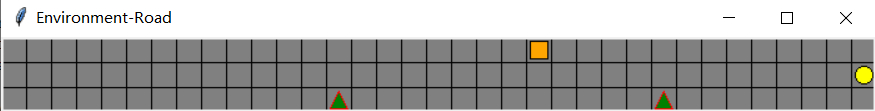

We use Tkinter to build a simple car driving environment. The entire environment is a 3*35 gray grid, where the first row represents the road where the car is driving, and a square that changes color as the speed changes is used to represent the vehicle, and the vehicle travels from left to right. The speed of the vehicle is represented by moving several squares at a time. For example, when the speed is 2, the vehicle will move two squares to the right in the next step. The initial speed is 3, the faster the vehicle speed, the darker its color. The vehicle has 5 actions [maintain speed, speed +1, speed +2, speed -1, speed -2]; 

A yellow circle in the second row indicates the end point, and the car passes the end point at the specified speed is a task to complete (which is 4); 

There are two red-edged green triangles in the third row, representing two pedestrians. The second task completion is the car not overspeeding past the pedestrian (the maximum speed of the car passing the pedestrian is 2). The two pedestrians randomly change their positions during each experiment to increase the complexity of the environment.

About reward setting:


---Effectiveness:



1. When the car passes the end point at the specified speed, the reward is increased by 60; otherwise, the reward is increased by -60.


2. Each step of the car will increase the reward of -4.


3. When the car speed is lower than the minimum speed (0), the reward of -16 is increased.
 
 
 ---Traffic rules:


1. When the car has a speeding (speed greater than 4) during the entire journey, the reward of -12 is added.


---Safety:


1. When the car is speeding past pedestrians (speed exceeds 2), the reward of -60 is increased.


---Comfort:
1. When the car speed is negative, the reward of -20 is increased.
Every time the car changes its behavior, the reward is increased by -3.


In [ ]:
"""
Environment part using tkinter to create.

1.Reference formula
:::S(t+1) = S(t) + V(t)Δt
:::V(t+1) = V(t) + a(t)Δt
2.Reward function with
:::reaching goal = global goal indicators
:::reaching velocity goal
:::per-step cost - This term discourages the driver from making unnecessary maneuvers
:::under-speed
:::over-speed
:::speed near obstacles
:::change in actions (esp. avoid stops and sudden braking)
3.Constraints
:::no acceleration allowed if that leads to v>v_max or deceleration that would cause v<0
:::The use of these hard constrains eliminates the clearly undesirable behaviors
better than through penalizing them in the reward function
:::It increases the learning speed during training
:::Also mask some actions:
if the ego car is driving at the maximum speed then the accelerate action is masked
"""

import time
import numpy as np  
import tkinter as tk
import logging


import time
import pickle
from copy import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from abc import ABC, abstractmethod
import os

import tensorflow as tf
import sys
from collections import defaultdict
plt.rcParams['figure.figsize'] = [20, 10]


import json  
from collections import deque
import math


In [ ]:
UNIT = 20   # pixels per grid cell
MAZE_H = 3  # grid height
MAZE_W = 35  # grid width (Need to adapt the threshold_success in the main accordingly)
HALF_SIZE = UNIT * 0.35  # half size factor of square in a cell
Y_COORD = 0  # blocking motion of ego agent in one row - no vertical motion allowed

In [ ]:
# Record some reports
class Logger:
    def __init__(self, module_name, logfile_name, log_level):
        """
        :param module_name: [string]
        :param logfile_name: [string]
        :param log_level: [int] in [0 - 4]
        """

        self.module_name = module_name
        self.severity_level_list = ["DEBUG", "INFO", "WARN", "ERROR", "FATAL"]
        self.logfile_name = logfile_name
        self.log_level_str = self.severity_level_list[log_level]
        self.log_level_int = log_level

        # logging configuration
        self.logger = logging.getLogger(self.module_name)  # instantiation
        self.logger.setLevel(self.log_level_str)  # lowest-severity log message a logger will handle
        # specify the layout of log records in the final output - ToDo: add milliseconds as well?
        self.formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                                           datefmt="%Y-%m-%d %H:%M:%S")
        self.file_handler = logging.FileHandler(self.logfile_name)  # Handlers send the log records
        self.file_handler.setFormatter(self.formatter)
        self.logger.addHandler(self.file_handler)

    def log(self, message, severity_level):
        # Report events that occur during normal operation of a program (for status monitoring or fault investigation)
        if severity_level == 0:  # Detailed information, typically of interest only when diagnosing problems
            self.logger.debug(message)
        elif severity_level == 1:  # Confirmation that things are working as expected
            self.logger.info(message)

        # Issue a warning regarding a particular runtime event
        if severity_level == 2:  # An indication that something unexpected happened / indicative of some problem in the
            # near future (e.g. ‘disk space low’). The software is still working as expected
            self.logger.warning(message)

        # Report suppression of an error without raising exception (e.g. error handler in a long-running server process)
        if severity_level == 3:  # Due to a more serious problem, the software hasn't been able to perform some function
            self.logger.error(message)
        if severity_level == 4:  # A serious error, indicating that the program itself may be unable to continue running
            self.logger.fatal(message)


In [ ]:
def one_hot_encoding(feature_to_encode):
    """
    :param feature_to_encode: int. For instance 5
    :return: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] if MAZE_W=10
    """
    repr_size = MAZE_W
    one_hot_list = np.zeros(repr_size)
    
    if feature_to_encode < repr_size:
        one_hot_list[feature_to_encode] = 1
    else:
        print('feature is out of scope for one_hot_encoding: %i / %i' % (feature_to_encode, repr_size))
    
    return one_hot_list

In [ ]:
def process_state(input_state):
    """
    extract features from the state to build an "observation"
    The agent may not know exactly its absolute position.
    But it may have an estimate of the relative distance to the obstacle
    Hence compute the difference in position
    :param input_state:
    :return: representation of the state understood by the RL agent
    """
    ego_position = input_state[0]
    velocity = input_state[1]
    
    # increase state for the brain
    return [ego_position, velocity]


In [ ]:
# Main Class about Environment 
class Road(tk.Tk, object): 
    def __init__(self, using_tkinter, actions_names, state_features, initial_state, goal_velocity=4):
        """
        :param using_tkinter: [bool] flag for the graphical interface
        :param actions_names: [string] list of possible actions
        :param state_features: [string] list of features forming the state
        :param initial_state: [list of int]
        :param goal_velocity: [int]
        """
        # graphical interface
        if using_tkinter:
            super(Road, self).__init__()

        # action space
        self.actions_list = actions_names

        # state is composed of
        # - absolute ego_position
        # - velocity
        # - absolute position of obstacle
        self.state_features = state_features
        # Reward - the reward is update
        # - during the transition (hard-constraints)
        # - in the reward_function (only considering the new state)
        self.reward = 0
        self.rewards_dict = {
            # efficiency = Progress
            "goal_with_good_velocity": 60,
            "goal_with_bad_velocity": -60,
            "per_step_cost": -4,
            "under_speed": -16,

            # traffic law
            "over_speed": -12,
            "over_speed_2": -12,

            # safety
            "over_speed_near_pedestrian": -60,

            # Comfort
            "negative_speed": -20,
            "action_change": -3
        }

        self.max_velocity_1 = 4
        self.max_velocity_2 = 2
        self.max_velocity_pedestrian = 2
        self.min_velocity = 0

        # state - for the moment distinct variables
        self.initial_state = initial_state
        self.state_ego_position = self.initial_state[0]
        self.state_ego_velocity = self.initial_state[1]
        self.state_obstacle_position = self.initial_state[2]
        self.state_obstacle_position1 = self.initial_state[3]
        self.previous_state_position = self.state_ego_position
        self.previous_state_velocity = self.state_ego_velocity
        self.previous_action = None

        # environment:
        self.goal_coord = [MAZE_W - 1, 1]
        self.goal_velocity = goal_velocity
        self.obstacle1_coord = [self.state_obstacle_position, 2]
        self.obstacle2_coord = [self.state_obstacle_position1, 2]
        self.initial_position = [self.initial_state[0], Y_COORD]

        # adjusting the colour of the agent depending on its speed
        colours_list = ["white", "yellow", "orange", "red2", "red3", "red4", "black", "black", "black", "black",
                        "black", "black"]
        velocity_list = range(len(colours_list)+1)
        self.colour_velocity_code = dict(zip(velocity_list, colours_list))

        # graphical interface
        self.using_tkinter = using_tkinter
        # create the origin point in  the Tk frame
        self.origin_coord = [(x + y) for x, y in zip(self.initial_position, [0.5, 0.5])]
        self.origin = [x * UNIT for x in self.origin_coord]
        self.canvas = None
        self.rect = None
        self.obstacle = None
        self.obstacle1 = None

        if self.using_tkinter:
            # Tk window
            self.title('Environment-Road')
            self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
            self.build_road()

        # logging configuration
        self.logger = Logger("road", "road_env.log", 0)

    @staticmethod
    def sample_position_obstacle():
        reset_position_obstacle = np.random.randint(low=7, high= 28)
        return reset_position_obstacle

    def build_road(self):
        """
        To build the Tk window
        Only called once at the start
        :return:  None
        """
        if self.using_tkinter:

            # create canvas
            self.canvas = tk.Canvas(self, bg='grey', height=MAZE_H * UNIT, width=MAZE_W * UNIT)

            # create grids
            for c in range(0, MAZE_W * UNIT, UNIT):
                x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
                self.canvas.create_line(x0, y0, x1, y1)
            for r in range(0, MAZE_H * UNIT, UNIT):
                x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
                self.canvas.create_line(x0, y0, x1, y1)

            # create ego agent
            self.rect = self.canvas.create_rectangle(
                self.origin[0] - HALF_SIZE, self.origin[1] - HALF_SIZE,
                self.origin[0] + HALF_SIZE, self.origin[1] + HALF_SIZE,
                fill='white')

            # obstacle1
            obstacle1_center = np.asarray(self.origin) + UNIT * np.asarray(self.obstacle1_coord)
            points = [obstacle1_center[0],obstacle1_center[1]-HALF_SIZE,
                      obstacle1_center[0]-HALF_SIZE,obstacle1_center[1]+HALF_SIZE,
                      obstacle1_center[0]+HALF_SIZE,obstacle1_center[1]+HALF_SIZE]
            self.obstacle = self.canvas.create_polygon(points,outline="red",fill='green')

            # obstacle2
            obstacle2_center = np.asarray(self.origin) + UNIT * np.asarray(self.obstacle2_coord)
            points = [obstacle2_center[0],obstacle2_center[1]-HALF_SIZE,
                      obstacle2_center[0]-HALF_SIZE,obstacle2_center[1]+HALF_SIZE,
                      obstacle2_center[0]+HALF_SIZE,obstacle2_center[1]+HALF_SIZE]
            self.obstacle1 = self.canvas.create_polygon(points,outline="red",fill='green')

            # create oval for the goal
            goal_center = np.asarray(self.origin) + UNIT * np.asarray(self.goal_coord)
            self.canvas.create_oval(
                goal_center[0] - HALF_SIZE, goal_center[1] - HALF_SIZE,
                goal_center[0] + HALF_SIZE, goal_center[1] + HALF_SIZE,
                fill='yellow')

            # pack all
            self.canvas.pack()

    def reset(self):
        """
        Clean the canvas (remove agent)
        Clean the state (reinitialize it)
        Sample a random position for the obstacle
        :return: the initial state amd the list of the masked actions
        """
        time.sleep(0.005)
        random_position_obstacle1 = self.sample_position_obstacle()
        random_position_obstacle2 = self.sample_position_obstacle()
        while random_position_obstacle1 == random_position_obstacle2: 
            random_position_obstacle2 = self.sample_position_obstacle()
        self.obstacle1_coord = [random_position_obstacle1, 2]
        self.obstacle2_coord = [random_position_obstacle2, 2]

        if self.using_tkinter:
            self.canvas.delete(self.rect)
            self.rect = self.canvas.create_rectangle(
                self.origin[0] - HALF_SIZE, self.origin[1] - HALF_SIZE,
                self.origin[0] + HALF_SIZE, self.origin[1] + HALF_SIZE,
                fill='white')

            self.canvas.delete(self.obstacle)
            self.canvas.delete(self.obstacle1)
            obstacle1_center = np.asarray(self.origin) + UNIT * np.asarray(self.obstacle1_coord)
            points = [obstacle1_center[0],obstacle1_center[1]-HALF_SIZE,
                      obstacle1_center[0]-HALF_SIZE,obstacle1_center[1]+HALF_SIZE,
                      obstacle1_center[0]+HALF_SIZE,obstacle1_center[1]+HALF_SIZE]
            self.obstacle = self.canvas.create_polygon(points,outline="red",fill='green')
            obstacle2_center = np.asarray(self.origin) + UNIT * np.asarray(self.obstacle2_coord)
            points = [obstacle2_center[0],obstacle2_center[1]-HALF_SIZE,
                      obstacle2_center[0]-HALF_SIZE,obstacle2_center[1]+HALF_SIZE,
                      obstacle2_center[0]+HALF_SIZE,obstacle2_center[1]+HALF_SIZE]
            self.obstacle1 = self.canvas.create_polygon(points,outline="red",fill='green')

        self.state_ego_position = self.initial_state[0]
        self.state_ego_velocity = self.initial_state[1]
        self.state_obstacle_position = random_position_obstacle1
        self.state_obstacle_position1 = random_position_obstacle2
        self.initial_state[2] = random_position_obstacle1
        self.initial_state[3] = random_position_obstacle2
        self.previous_state_position = self.initial_state[0]
        self.previous_state_velocity = self.initial_state[1]

        return process_state(self.initial_state), self.masking_function()

    def transition(self, action, velocity=None):
        """
        update velocity in state according to the desired command
        :param action: desired action
        :param velocity: [optional]
        :return:
        """
        if velocity is None:
            velocity = self.state_ego_velocity

        delta_velocity = 0

        # print("current velocity: %s" % self.state_ego_velocity)
        if action == self.actions_list[0]:  # maintain velocity
            delta_velocity = 0
        elif action == self.actions_list[1]:  # accelerate
            delta_velocity = 1
        elif action == self.actions_list[2]:  # accelerate a lot
            delta_velocity = 2
        elif action == self.actions_list[3]:  # slow down
            delta_velocity = -1
        elif action == self.actions_list[4]:  # slow down a lot
            delta_velocity = -2
        # print("new velocity: %s" % self.state_ego_velocity)

        return velocity + delta_velocity

    def step(self, action):
        """
        Transforms the action into the new state
        -calls the transition model
        -calls checks hard conditions
        -calls masking - to be implemented
        :param action: [string] the desired action
        :return: tuple with:
        -new state (list)
        -reward (int)
        -termination_flag (bool)
        -masked_actions_list (list)
        """
        # reminding the previous state
        self.previous_state_velocity = self.state_ego_velocity
        self.previous_state_position = self.state_ego_position
        self.previous_action = action

        # Transition = get the new state:
        self.state_ego_velocity = self.transition(action)
        if self.state_ego_velocity < 0:
            self.state_ego_velocity = 0
            message = "self.state_ego_velocity cannot be < 0 - a = {} - p = {} - v = {} " \
                      "in step()".format(action, self.state_ego_position, self.state_ego_velocity)
            self.logger.log(message, 3)

        # Assume simple relation: velocity expressed in [step/sec] and time step = 1s
        desired_position_change = self.state_ego_velocity

        # convert information from velocity to the change in position = number of steps
        tk_update_steps = [0, 0]

        # update the state - position
        self.state_ego_position = self.state_ego_position + desired_position_change
        tk_update_steps[0] += desired_position_change * UNIT

        if self.using_tkinter:
            # move agent in canvas
            self.canvas.move(self.rect, tk_update_steps[0], tk_update_steps[1])
            # update colour depending on speed
            new_colour = self.colour_velocity_code[self.state_ego_velocity]
            self.canvas.itemconfig(self.rect, fill=new_colour)

        # observe reward
        [reward, termination_flag] = self.reward_function(action)

        # for the next decision, these actions are not possible (it uses the output state):
        if termination_flag:
            masked_actions_list = []
        else:
            masked_actions_list = self.masking_function()

        state_to_return = process_state(
            [self.state_ego_position, self.state_ego_velocity, self.state_obstacle_position]
        )
        return state_to_return, reward, termination_flag, masked_actions_list

    def reward_function(self, action):
        """
        It needs to consider all the intermediate points between previous state and new state
        :return: the reward (int) and termination_flag (bool)
        """
        # reward put to for the new step
        self.reward = 0

        # penalizing changes in action
        # it penalizes big changes (e.g. from speed_up_up to slow_down_down)
        if self.state_ego_velocity != self.previous_state_velocity:
            change_in_velocity = self.state_ego_velocity - self.previous_state_velocity
            self.reward += self.rewards_dict["action_change"] * abs(change_in_velocity)

        # test about the position
        # - for the goal
        if self.state_ego_position >= self.goal_coord[0]:
            # not over-exceeding the goal
            self.state_ego_position = self.goal_coord[0]
            if self.state_ego_velocity == self.goal_velocity:
                self.reward += self.rewards_dict["goal_with_good_velocity"]
            else:
                self.reward += self.rewards_dict["goal_with_bad_velocity"]
            termination_flag = True

        # - for all other states
        else:
            self.reward += self.rewards_dict["per_step_cost"]
            termination_flag = False

        # check max speed limitation
        if self.state_ego_velocity > self.max_velocity_1:
            excess_in_velocity = self.state_ego_velocity - self.max_velocity_1
            self.reward += self.rewards_dict["over_speed"] * excess_in_velocity
            message = "Too fast! in reward_function() -- hard constraints should have masked it. " \
                      "a = {} - p = {} - v = {}".format(action, self.state_ego_position, self.state_ego_velocity)
            self.logger.log(message, 3)

        # check minimal speed
        if self.state_ego_velocity < self.min_velocity:
            excess_in_velocity = self.min_velocity - self.state_ego_velocity
            # well, basically, it will stay as rest - but still, we need to prevent negative speeds
            self.reward += self.rewards_dict["under_speed"] * excess_in_velocity

            if self.state_ego_velocity < 0:
                excess_in_velocity = abs(self.min_velocity)
                message = "Under speed! in reward_function() -- hard constraints should have masked it. " \
                          "a = {} - p = {} - v = {}".format(action, self.state_ego_position, self.state_ego_velocity)
                self.logger.log(message, 3)

                self.state_ego_velocity = 0
                self.reward += self.rewards_dict["negative_speed"] * excess_in_velocity

        # limit speed when driving close to a pedestrian
        if self.previous_state_position <= self.obstacle1_coord[0] <= self.state_ego_position:
            if self.state_ego_velocity > self.max_velocity_pedestrian:
                excess_in_velocity = self.state_ego_velocity - self.max_velocity_pedestrian
                self.reward += self.rewards_dict["over_speed_near_pedestrian"] * excess_in_velocity
                message = "Too fast close to obstacle! in reward_function() - a = {} - p = {} - po= {} - v = {}".format(
                    action, self.state_ego_position, self.state_obstacle_position, self.state_ego_velocity)
                self.logger.log(message, 1)
        if self.previous_state_position <= self.obstacle2_coord[0] <= self.state_ego_position:
            if self.state_ego_velocity > self.max_velocity_pedestrian:
                excess_in_velocity = self.state_ego_velocity - self.max_velocity_pedestrian
                self.reward += self.rewards_dict["over_speed_near_pedestrian"] * excess_in_velocity
                message = "Too fast close to obstacle! in reward_function() - a = {} - p = {} - po= {} - v = {}".format(
                    action, self.state_ego_position, self.state_obstacle_position, self.state_ego_velocity)
                self.logger.log(message, 1)

        return self.reward, termination_flag

    def masking_function(self, state=None):
        """
        hard constraints
        using the state (position, velocity)
        :param state: [optional]
        :return: masked_actions_list (a sub_list from self.action_list)
        """

        if state is None:
            velocity = None
        else:
            velocity = state[1]

        masked_actions_list = []

        # check if maximum / minimum speed has been reached
        for action_candidate in self.actions_list:
            # simulation for each action
            velocity_candidate = self.transition(action_candidate, velocity)
            if velocity_candidate > self.max_velocity_1:
                masked_actions_list.append(action_candidate)
            elif velocity_candidate < 0:
                masked_actions_list.append(action_candidate)

        # checking there are still possibilities left:
        if masked_actions_list == self.actions_list:
            print("WARNING - velocity %s and position %s" % (self.state_ego_velocity, self.state_ego_position))
            message = "No possible_action found! in masking_function() - a = {} - p = {} - po= {} - v = {}".format(
                self.previous_action, self.state_ego_position, self.state_obstacle_position, self.state_ego_velocity)
            self.logger.log(message, 4)

        return masked_actions_list

    def move_to_state(self, state):
        """
        teleportation for model-based DP
        :return:
        """
        self.state_ego_position = state[0]
        self.state_ego_velocity = state[1]
        pass

    def render(self, sleep_time):
        """
        :param sleep_time: [float]
        necessary for demo()
        :return:
        """
        if self.using_tkinter:
            time.sleep(sleep_time)
            self.update()


### **Agent**
The driving brain/vehicle on the road

In [ ]:
class Agent(ABC):
    def __init__(self, actions_names, state_features, load_q_table=False):
        # environment parameters
        self.actions_list = actions_names 
        self.state_features_list = state_features  
        self.columns_q_table = actions_names + state_features  
        
        # other parameters
        self.max_size = 800
        self.reference_list = []
        colors = ['green', 'red', 'blue', 'yellow', 'orange']
        self.act_color_map = dict(zip(self.actions_list, colors))

        self.q_table = None
        if load_q_table:
            if self.load_q_table():
                print("Load success")
            else:
                self.reset_q_table()
        else:
            self.reset_q_table()
        
        
  

        
    def reset_q_table(self):
        self.q_table = pd.DataFrame(columns=self.columns_q_table, dtype=np.float32)
        print("reset_q_table - self.q_table has shape = {}".format(self.q_table.shape))

        
    def choose_action(self, observation, masked_actions_list, greedy_epsilon):
        self.check_state_exist(observation)
        possible_acts = [a for a in self.actions_list if a not in masked_actions_list]
        # use epsilon-greedy algorithm for action selecting
        if np.random.uniform() > greedy_epsilon:
            # choose best action
            act_cur_state = self.q_table.loc[
                (self.q_table[self.state_features_list[0]] == observation[0])
                & (self.q_table[self.state_features_list[1]] == observation[1])]
            act_cur_state = act_cur_state.filter(self.actions_list, axis=1)
            # shuffle actions if there is a tie of q-values, chose randomly, not always the first one
            act_cur_state = act_cur_state.reindex(np.random.permutation(act_cur_state.index))
            # restrict to allowed actions
            act_cur_state = act_cur_state.filter(items=possible_acts)
        
            # make decision
            if act_cur_state.empty:
                action = random.choice(possible_acts)
            else:
                action = act_cur_state.idxmax(axis=1)
            # retrieve the action to do
            next_act = action.iloc[0]
            
        else:
            # select the action randomly
            next_act = np.random.choice(possible_acts)
    
        return next_act

    
    def compare_reference_value(self):
        """
        we know the value of the last-but one state at convergence: Q(s,a)=R(s,a).
        since if termination_flag: q_target = r (# goal state has no value)
        :return: the value of a given (state, action) pair
        """
        state = [16, 3]
        action_id = 0  # have no change
        self.check_state_exist(state)
        prev_state_row_id = self.get_id_row_state(state)
        res = self.q_table.loc[prev_state_row_id, self.actions_list[action_id]]
        self.reference_list.append(res)
        return res

    
    @abstractmethod
    def learn(self, *args):
        """
        Update the agent's knowledge, using the most recently sampled tuple
        This method is implemented in each children agent
        """
        pass

    
    def check_state_exist(self, state):
        """
        read if the state has already be encountered
        if not, add it to the table and initialize its q-value
        with collections.defaultdict or np.array, this would have not be required
        """
        # get the index of the state
        state_ids_prev_state = self.q_table.index[(self.q_table[self.state_features_list[0]] == state[0]) &
                                                          (self.q_table[self.state_features_list[1]] ==
                                                           state[1])].tolist()

        if not state_ids_prev_state:
            # add the new state into the q table
            new_data = np.concatenate((np.array(len(self.actions_list)*[0]), np.array(state)), axis=0)
            new_row = pd.Series(new_data, index=self.q_table.columns)
            self.q_table = self.q_table.append(new_row, ignore_index=True)

            
    def get_id_row_state(self, s):
        id_list_state = self.q_table.index[(self.q_table[self.state_features_list[0]] == s[0]) &
                                           (self.q_table[self.state_features_list[1]] == s[1])].tolist()
        return id_list_state[0]

    
    def load_q_table(self, weight_file=None):
        try:
            if weight_file is None:
                pdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
                res_dir = os.path.abspath(pdir + "/results/simple_road/" + "q_table" + '.pkl')
                self.q_table = pd.read_pickle(res_dir)
            else:
                self.q_table = pd.read_pickle(weight_file)
            return True

        except Exception as e:
            print(e)
        return False

    
    def save_q_table(self, save_directory):
        filename = "q_table"
        # sort by positions
        self.q_table = self.q_table.sort_values(by=[self.state_features_list[0]])
        try:
            self.q_table.to_pickle(save_directory + filename + ".pkl")
            print("Saved as " + filename + ".pkl")
        except Exception as e:
            print(e)

            
    def print_q_table(self):
        # sort by positions
        self.q_table = self.q_table.sort_values(by=[self.state_features_list[0]])
        print(self.q_table.to_string())

        
    def plot_q_table(self, folder, display_flag):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        # avoid overlap scatters
        dev = 0.2

        # normalization
        min_value = min(self.q_table[self.actions_list].min(axis=0))
        max_value = max(self.q_table[self.actions_list].max(axis=0))

        scale_factor = self.max_size / max(max_value, abs(min_value))
        i = 0
        for action in self.actions_list:
            color_for_action = self.act_color_map[action]
            color_for_action_neg = color_for_action
            markers = ['P' if i > 0 else 's' for i in self.q_table[action]]
            sizes = [scale_factor * (abs(i)) for i in self.q_table[action]]
            colors = [color_for_action if i > 0 else color_for_action_neg for i in self.q_table[action]]
            for x, y, m, s, c in zip(self.q_table[self.state_features_list[0]],
                                     self.q_table[self.state_features_list[1]], markers, sizes, colors):
                ax1.scatter(x, y + i*dev, alpha=0.8, c=c, marker=m, s=s)
            i += 1


        labels_list = []
        for action in self.actions_list:
            label = patches.Patch(color=self.act_color_map[action], label=action)
            labels_list.append(label)
        plt.legend(handles=labels_list)
        plt.title('Normalized Q(s,a) - distinguishing positive and negative values with marker type')
        plt.xlabel(self.state_features_list[0])
        plt.ylabel(self.state_features_list[1])
        plt.xticks(np.arange(min(self.q_table[self.state_features_list[0]]),
                             max(self.q_table[self.state_features_list[0]]) + 1, 1.0))
        plt.grid(True, alpha=0.2)
        ax1.set_facecolor('silver')
        plt.savefig(folder + "plot_q_table.png", dpi=800)
        if display_flag:
            plt.show()

            
    def plot_optimal_actions_at_each_position(self, folder, display_flag):
        # normalization
        min_value = min(self.q_table[self.actions_list].min(axis=0))
        max_value = max(self.q_table[self.actions_list].max(axis=0))
        scale_factor = self.max_size / max(max_value, abs(min_value))

        # look for the best action for each state
        fig = plt.figure()
        ax2 = fig.add_subplot(111)
        for index, row in self.q_table.iterrows():
            action_value = row.filter(self.actions_list, axis=0)
            action = action_value.idxmax()
            value = action_value.max()
            x = row[self.state_features_list[0]]
            y = row[self.state_features_list[1]]
            c = self.act_color_map[action]

            if value > 0:
                m = 'P'
            else:
                m = 's'
            s = scale_factor * abs(value)
            ax2.scatter(x, y, alpha=0.8, c=c, marker=m, s=s)

    
        labels_list = []
        for action in self.actions_list:
            label = patches.Patch(color=self.act_color_map[action], label=action)
            labels_list.append(label)
        plt.legend(handles=labels_list)
        plt.title('Normalized max[Q(s,a)][over a] - Optimal actions - randomly selected if equal')
        plt.xlabel(self.state_features_list[0])
        plt.ylabel(self.state_features_list[1])
        plt.xticks(np.arange(min(self.q_table[self.state_features_list[0]]),
                             max(self.q_table[self.state_features_list[0]]) + 1, 1.0))
        plt.grid(True, alpha=0.2)
        ax2.set_facecolor('silver')
        plt.savefig(folder + "plot_optimal_actions_at_each_position.png", dpi=800)
        if display_flag: plt.show()

### **Algorithms**


#### **SARSA**

In [ ]:
#SARSA updates while in the current trajectory
# SARSA can only learn from itself (from the experience and transition it met in the past)
class SarsaTable(Agent):
    def __init__(self, actions, state, loadQTable=False):
        super(SarsaTable, self).__init__(actions, state, loadQTable)

    def learn(self, s, a, r, s_, a_, terminationFlag, gamma, learning_rate):
        """
         update the q-table based on the observed experience SARSA
         using the actual action a_ to evaluate Q(s_, a_)
         q_expected = Q(s_, a_)
         s: previous state (list of int)
         a: action (str)
         r: reward (int)
         s_: new state (list of int)
         terminationFlag: (boolean)
         a_: new action (str)
         gamma: [float between 0 and 1] discount factor
         learning_rate: [float between 0 and 1] - learning rate
        """
        self.check_state_exist(s_)

        #id of the row of the previous state
        previous_state_row_id = self.get_id_row_state(s)

        #id of the row of the next state
        next_state_row_id = self.get_id_row_state(s_)

        #q-value of the pair (previous_state, action)
        q_predict = self.q_table.loc[previous_state_row_id, a]

        # Check if new state is terminal
        if terminationFlag:
            # next state is terminal
            # goal state has no value
            q_target = r
        else:
            # next state is not terminal
            q_expected = self.q_table.loc[next_state_row_id, a_]
            q_target = r + gamma * q_expected

        # update q-value - Delta is the TD-error
        self.q_table.loc[previous_state_row_id, a] += learning_rate * (q_target - q_predict)

#### **SARSA Lambda**

In [ ]:
# Sarsa Lambda can learn for
# - 1 step (Sarsa) (lambda=0)
# - All the episode (Monte Carlo) (lambda=1)
# - in between (Lambda in [0,1])
# Idea is to update and give reward to all the steps that contribute to the end return
class SarsaLambdaTable(Agent):
    def __init__(self, actions, state, loadQTable=False,
                 trace_decay=0.9):
        super(SarsaLambdaTable, self).__init__(actions, state, loadQTable)

        # backward view, eligibility trace.
        self.lambda_trace_decay = trace_decay
        # same dimension as the Q-table: it counts how many times the state has been visited
        self.eligibility_trace = self.q_table.copy()

    def reset_eligibility_trace(self):
        # self.eligibility_trace *= 0
        self.eligibility_trace[self.actions_list] = 0.0

    def check_state_exist(self, state):
        """
        read if the state has already be encountered
        if not, add it to the table
        update the eligibility_trace too
        :param state:
        :return: -
        """
        # try to find the index of the state - same as for the parent Class
        state_id_list_previous_state = self.q_table.index[(self.q_table[self.state_features_list[0]] == state[0]) &
                                                          (self.q_table[self.state_features_list[1]] ==
                                                           state[1])].tolist()

        if not state_id_list_previous_state:
            # append new state to q table: Q(a,s)=0 for each action a
            new_data = np.concatenate((np.array(len(self.actions_list) * [0]), np.array(state)), axis=0)
            new_row = pd.Series(new_data, index=self.q_table.columns)

            # add new row in q_table
            self.q_table = self.q_table.append(new_row, ignore_index=True)

            # also add it to the eligibility trace
            self.eligibility_trace = self.eligibility_trace.append(new_row, ignore_index=True)

    def learn(self, s, a, r, s_, a_, termination_flag, gamma, learning_rate):
        """
        update the q-table based on the observed experience SARSA
        update the eligibility_trace too
        s: previous state (list of int)
        a: action (str)
        r: reward (int)
        s_: new state (list of int)
        termination_flag: (boolean)
        a_: new action (str)
        gamma: [float between 0 and 1] discount factor
        learning_rate: [float between 0 and 1] - learning rate
        """
        self.check_state_exist(s_)

        #id of the row of the previous state
        previous_state_id_row = self.get_id_row_state(s)

        #id of the row of the next state
        id_row_next_state = self.get_id_row_state(s_)

        #q-value of the tuple (previous_state, action)
        q_predict = self.q_table.loc[previous_state_id_row, a]

        # Check if new state is terminal
        if termination_flag:
            # next state is terminal
            # goal state has no value
            q_target = r
        else:
            # next state is not terminal
            # consider the value of the next state with the action a_
            # using the actual action a_ to evaluate Q(s_, a_) - SARSA is therefore said "on-policy"
            q_expected = self.q_table.loc[id_row_next_state, a_]
            q_target = r + gamma * q_expected

        # TD-error
        error = q_target - q_predict
        # sarsa would have just done:
        # self.q_table.loc[previous_state_id_row, a] += learning_rate * (q_target - q_predict)

        # increasing the importance factor for the visited state-action pair. Two methods:
        # Method 1: accumulating trace (not quite stable)
        # self.eligibility_trace.loc[previous_state_id_row, a] += 1

        # Method 2: replacing trace (normalization) - if I visit a state more than once, it still stays at 1, not more
        self.eligibility_trace.loc[previous_state_id_row, a] = 1

        # q_table update - most state will not be considered
        # The importance factor (=eligibility_trace) says how important is to travel by this state to get the return
        self.q_table[self.actions_list] += learning_rate * error * self.eligibility_trace[self.actions_list]

        # decay eligibility trace after update (before the next step)
        self.eligibility_trace[self.actions_list] *= gamma * self.lambda_trace_decay




#### **Q-Learning**

In [ ]:
# off-policy. Q-learning = sarsa_max
class QLearningTable(Agent):
    def __init__(self, actions, state, loadQTable=False):
        super(QLearningTable, self).__init__(actions, state, loadQTable)

    def learn(self, s, a, r, s_, terminationFlag, gamma, learning_rate):
        """
        update the q-table based on the observed experience SARSA
         s: previous state (list of int)
         a: action (str)
         r: reward (int)
         s_: new state (list of int)
         terminationFlag: (boolean)
         gamma: [float between 0 and 1] discount factor
         learning_rate: [float between 0 and 1] - learning rate
        """
        self.check_state_exist(s_)

        #id of the row of the previous state
        previous_state_row_id = self.get_id_row_state(s)

        #id of the row of the next state
        next_state_row_id = self.get_id_row_state(s_)

        #q-value of the tuple (previous_state, action)
        q_predict = self.q_table.loc[previous_state_row_id, a]

        #Check if new state is terminal
        if terminationFlag:
            # next state is terminal
            # goal state has no value
            q_target = r
            # Trying to reduce chance of random action as we train the model.

        else:
            # next state is not terminal
            # consider the best value of the next state. Q-learning = sarsa_max
            # using max to evaluate Q(s_, a_)
            row = self.q_table.loc[next_state_row_id]
            filtered_row = row.filter(self.actions_list)
          
            q_expected = max(filtered_row)
            q_target = r + gamma * q_expected

        # update q-value following Q-learning - Delta is the TD-error
        self.q_table.loc[previous_state_row_id, a] += learning_rate * (q_target - q_predict)

#### **Monte Carlo**

In [ ]:
# Monte Carlo
class MC(Agent):
    def __init__(self, actions, state, loadQTable=False):
        super(MC, self).__init__(actions, state, loadQTable)
        self.nA = len(actions)

    def compare_reference_value(self):
        state = (16, 3)
        action_id = 0  # "no change"
        res = self.q_table[state][action_id]
        print("reference_value = {}".format(res))
        return res

    def reset_q_table(self):
        self.q_table = defaultdict(lambda: np.zeros(self.nA))

    def choose_action(self, observation, masked_actions_list, greedy_epsilon):
        observation = tuple(observation)

        # apply action masking
        possible_actions = [action for action in self.actions_list if action not in masked_actions_list]

        # Epsilon-greedy action selection
        if np.random.uniform() > greedy_epsilon:
            # choose best action

            state_action = copy(self.q_table[observation])
            # restrict to allowed actions
            for action in self.actions_list:
                if action not in possible_actions:
                    action_id = self.actions_list.index(action)
                    state_action[action_id] = -np.inf  # using a copy
            # make decision
            if np.all(np.isneginf([state_action])):
                action_id = random.choice(possible_actions)
                print('random action sampled among allowed actions')
            else:
                action_id = np.argmax(state_action)
                # Return index of first occurrence of maximum over requested axis (with shuffle)
            action_to_do = self.actions_list[action_id]
        else:
            action_to_do = np.random.choice(possible_actions)

        return action_to_do

    def learn(self, episode, gamma, learning_rate):
        """ 
        updates the action-value function estimate 
        using the most recent episode 
        """
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])
        for i, state in enumerate(states):
            action_id = self.actions_list.index(actions[i])
            old_q = self.q_table[state][action_id]
            self.q_table[state][action_id] = old_q + learning_rate * (sum(rewards[i:] * discounts[:-(1 + i)]) - old_q)

    def save_q_table(self, save_directory):
        filename = "q_table"
        try:
            output = open(save_directory + filename + ".pkl", 'wb')

            pickle.dump(dict(self.q_table), output)
            output.close()
            print("Saved as " + filename + ".pkl")

        except Exception as e:
            print(e)

    def print_q_table(self):
        # sort series according to the position
        dict_q_table = dict(self.q_table)
        pandas_q_table = pd.DataFrame(columns=self.columns_q_table, dtype=np.float32)
        for state, q_values in dict_q_table.items():
            new_data = np.concatenate((np.array(q_values), np.array(state)), axis=0)
            new_row = pd.Series(new_data, index=pandas_q_table.columns)
            pandas_q_table = pandas_q_table.append(new_row, ignore_index=True)

        pandas_q_table = pandas_q_table.sort_values(by=[self.state_features_list[0]])
        print(pandas_q_table.to_string())

    def load_q_table(self, weight_file=None):
        """
        open_model
        working with h5, csv or pickle format
        :return: -
        """
        try:
            print(weight_file)
            loaded_dict = pd.read_pickle(weight_file)
            print(type(loaded_dict))

            self.q_table = defaultdict(lambda: np.zeros(self.nA))

            for state, value in loaded_dict.items():
                for i, q in enumerate(value):
                    self.q_table[state][i] = q
            return True

        except Exception as e:
            print(e)
        return False

#### **Dynamic Programming (Model-Based)**
The Dynamic Programming algorithm has access to the Reward and Transition functions. Agent used to get the optimal values (to set the success_threshold)

In [ ]:

class DP(Agent):
    def __init__(self, actions, state, env, gamma, load_q_table=False):
        super(DP, self).__init__(actions, state, load_q_table)
        self.env = env
        self.nA = len(actions)
        self.n_position = 35
        self.n_velocity = 6
        self.gamma = gamma

    def learn(self):
        pass

    def get_value_from_state(self, state, action):
        [p, v] = state
        self.env.reset()
        self.env.move_to_state([p, v])  # teleportation
        next_obs, reward, is_done, _ = self.env.step(action)
        return next_obs, reward, is_done

    
    
    def run_policy(self, policy, init_state, steps_num_max=100):
        # run one episode with a policy
        self.env.reset()
        v_table = self.policy_evaluation(policy=policy)
        q_table = self.q_from_v(v_table)
        cur_obs = init_state
        self.env.move_to_state(init_state)  
        return_rewards = 0
        trajectory = []
        step_num = 0
        
        while step_num < steps_num_max:
            step_num += 1
            cur_state_policy = policy[cur_obs[0], cur_obs[1]]
            print("current state policy is {}".format(cur_state_policy))
            print("current state q_values is {}".format(q_table[cur_obs[0], cur_obs[1]]))

            act_id = np.argmax(policy[cur_obs[0], cur_obs[1]])
            action = self.actions_list[act_id]
            print("action is {}".format(action))

            trajectory.append(cur_obs)
            trajectory.append(action)

            next_obs, reward, is_done, _ = self.env.step(action)
            print(" {}, {}, {} = results".format(next_obs, reward, is_done))

            return_rewards += reward
            cur_obs = next_obs
            if is_done:
                trajectory.append(next_obs)
                break

        print("Return Rewards = {}".format(return_rewards))
        print("Trajectory = {}".format(trajectory))
        return return_rewards, trajectory

    
    
    def q_from_v(self, v_table):
        """
        from the Value Function (for each state) to the Q-value Function (for each [state, action] pair)
        it makes sure masked actions have -np.inf values
        """
        q_table = np.ones((self.n_position, self.n_velocity, self.nA))

        # iterate through all possible states (p, v)
        for p in range(self.n_position):
            for v in range(self.n_velocity):
                masked_actions_list = self.env.masking_function([p, v])
                possible_actions = [action for action in self.actions_list if action not in masked_actions_list]
            
                for act_id in range(self.nA):
                    self.env.move_to_state([p, v])  # say the env to move on on state [p][v]
                    action = self.actions_list[act_id]
                    if action in possible_actions:
                        next_obs, reward, is_done, _ = self.env.step(action)
                        prob = 1  # it is a deterministic environment
                        if is_done:
                            
                            q_table[p][v][act_id] = prob * reward

                        else:
                            next_p = next_obs[0]
                            next_v = next_obs[1]
                            q_table[p][v][act_id] = prob * (reward + self.gamma * v_table[next_p][next_v])

                    else:
                        q_table[p][v][act_id] = -np.inf  # masked action
                        
        return q_table

    
    
    def policy_improvement(self, v_table):
        policy = np.zeros([self.n_position, self.n_velocity, self.nA]) / self.nA
        for p in range(self.n_position):
            for v in range(self.n_velocity):
                q_table = self.q_from_v(v_table)
                # construct a stochastic policy that puts equal probability on maximizing actions
                best_a = np.argwhere(q_table[p][v] == np.max(q_table[p][v])).flatten()
                policy[p][v] = np.sum([np.eye(self.nA)[i] for i in best_a], axis=0) / len(best_a)

        return policy

   
    def policy_evaluation(self, theta_func=10e-3, policy=None, max_counter=1e3):
        if policy is None:
            policy = np.ones([self.n_position, self.n_velocity, self.nA]) / self.nA  # random_policy
        # initialize arbitrarily
        v_table = np.zeros((self.n_position, self.n_velocity))
        counter = 0
        while counter < max_counter:

            counter += 1
            if counter % 1000 == 0:
                print(" --- {} policy_evaluation --- ".format(counter))
            delta_func = 0

            # iterate through all possible states (p, v)
            for p in range(self.n_position):
                for v in range(self.n_velocity):

                    v_state = 0
                    masked_actions_list = self.env.masking_function([p, v])
                   

                    possible_actions = [action for action in self.actions_list if action not in masked_actions_list]
                 
                    for act_id, action_prob in enumerate(policy[p][v]):
                        self.env.move_to_state([p, v]) 
                        
                        action = self.actions_list[act_id]
                        if action in possible_actions:
                            
                            next_obs, reward, is_done, _ = self.env.step(action)
                            prob = 1  # deterministic environment
                            
                            next_p = next_obs[0]
                            next_v = next_obs[1]
                           
                            if is_done:
                                v_state += action_prob * prob * reward
                            else:
                                v_state += action_prob * prob * (reward + self.gamma * v_table[next_p][next_v])
                    delta_func = max(delta_func, np.abs(v_table[p][v] - v_state))
                    v_table[p][v] = v_state
                    
            if delta_func < theta_func: break
                
        return v_table

    
    
    # truncated Policy_Iteration
    def policy_iteration(self, theta_func=1e-3, theta_final_value_function=1e-5, max_counter=1e3):
        time_start = time.time()
        policy = np.zeros([self.n_position, self.n_velocity, self.nA]) / self.nA
        counter = 0
        v_table = None
        delta_policy = None

        while counter < max_counter:
            counter += 1
            time_mid = time.time()
            duration = time_mid - time_start
            print(" - {}-th iteration in Policy_Iteration - duration = {:.2f} - delta_policy = {}".format(
                counter, duration, delta_policy))

            # For fixed current policy, find values with policy evaluation
            v_table = self.policy_evaluation(theta_func=theta_func,
                                             policy=policy,
                                             max_counter=max_counter)
            new_policy = self.policy_improvement(v_table)
            delta_policy = np.max(abs(self.policy_evaluation(policy=policy,
                                                             theta_func=theta_func,
                                                             max_counter=max_counter)
                                      - self.policy_evaluation(policy=new_policy,
                                                               theta_func=theta_func,
                                                               max_counter=max_counter)
                                      ))
            if delta_policy < theta_final_value_function: break
            policy = copy(new_policy)

        time_end = time.time()
        duration = time_end - time_start
        if counter == max_counter:
            print("PI stops because of max_counter = {}".format(max_counter))
        else:
            print("PI stops because of theta value function = {}".format(theta_func))
        print("Duration of Policy Iteration = {:.2f} - counter = {} - delta_policy = {}".format(duration, counter, delta_policy))
        return policy, v_table

    
    
    def value_iteration(self, theta_func=1e-5, max_counter=1e3):
        time_start = time.time()

        # initialize V arbitrarily
        v_table = np.zeros((self.n_position, self.n_velocity))
        counter = 0
        delta_func = None

        while counter < max_counter:
            counter += 1
            time_mid = time.time()
            duration = time_mid - time_start
            print(" - {}-th iteration in Value_Iteration - duration = {:.2f} - delta_func = {}".format(
                counter, duration, delta_func))

            delta_func = 0
            # iterate through all states
            for p in range(self.n_position):
                for v in range(self.n_velocity):
                    value = v_table[p][v]
                    q_table = self.q_from_v(v_table)
                    v_table[p][v] = np.max(q_table[p][v])

                    # check the degree of value changed
                    delta_func = max(delta_func, abs(v_table[p][v] - value))
            if delta_func < theta_func: break
                
        # now, we get the Optimal value function, we need to retrieve its policy
        policy = self.policy_improvement(v_table)
        time_end = time.time()
        duration = time_end - time_start
        if counter == max_counter:
            print("VI stops because of max_counter = {}".format(max_counter))
        else:
            print("VI stops because of theta_func = {}".format(theta_func))
        print("Duration of Value Iteration = {:.2f} - counter = {} - delta_func = {}".format(
            duration, counter, delta_func))

        return policy, v_table

#### **Deep Q-Learning (Tensorflow)**

Deep Q-Learning is a reinforcement learning algorithm that combines Q-Learning with deep neural networks to let RL work for complex, high-dimensional environments.

We using Tensorflow to implement our Deep Q-Learning algorith.


In [ ]:
if "../" not in sys.path:
    sys.path.append("../")

np.random.seed(1)
tf.set_random_seed(1)

# Create a global step variable
global_step = tf.Variable(0, name='global_step', trainable=False)


def normalization_function(targets_batch_to_normalize):
    mini_target_value = -100
    maxi_target_value = +100
    res = (targets_batch_to_normalize - mini_target_value) / (maxi_target_value - mini_target_value)

    return res


def inverse_normalization_function(targets_batch_to_inverse_normalize):
    mini_target_value = -10000
    maxi_target_value = +10000
    res = targets_batch_to_inverse_normalize * (maxi_target_value - mini_target_value) + mini_target_value

    return res


def normalize_reward(r):
    # Parameters to rescale the rewards, but don’t shift mean, as that affects agent’s will to live
    mini_reward = -50
    maxi_reward = 40
    reward = r / (maxi_reward - mini_reward)
    return reward


##### 1. Pseudocode
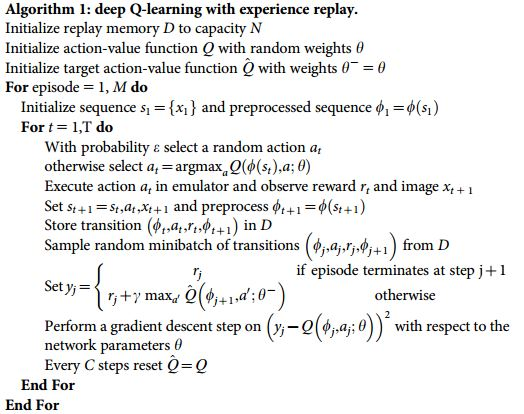


##### 2. Steps
###### 1. Build Network
We build two networks, target network and evaluate network. Target network is a historical version of evaluate network. It includes parameters from the previous version of the evaluation network. Those parameters will not be changed during some preset time. Then it will be changed by the new parameters from the evaluate network. And the evaluate network is trainable.
###### 2. Store the transition in memory
Store the transition that the agent obsers, then those observations can be reused for the model to learn.
###### 3. Choose action
Similar to Q learning and Sarsa, DQN will choose action based on the epsilon. It will exploration to choose a random action or exploitation to choose the action that has largest Q value
###### 4. Learning
The learning process will allow the agent to update parameters and keep improvement. In the DQN, we will perform a gradient descent step on the evaluate network.



##### 3. Network Graph
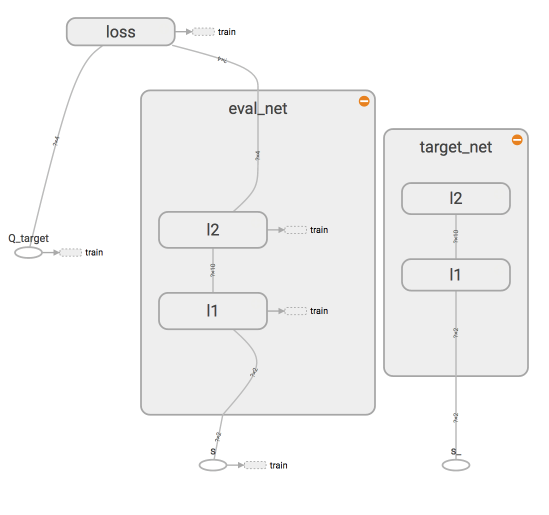

In [ ]:
# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            actions,
            state,
            learning_rate=0.02,
            reward_decay=0.9,
            epsilon_max=0.9,
            replace_target_iter=300,
            memory_size=50,
            batch_size=32,
            epsilon_greedy_increment=None,
            summaries_dir=None,  # log-dir
            saver_dir=None
    ):

        self.actions_list = actions
        self.action_taken = None
        self.state_features_list = state

        self.n_actions = len(actions)
        self.n_features = len(state)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = epsilon_max
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_greedy_increment = epsilon_greedy_increment
#         self.epsilon = 0 if epsilon_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learning_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        # each row is like [state, action, reward, state] = ['0' '3' 'slow_down_down' '-7' '1' '1']
        self.memory = np.zeros((self.memory_size, self.n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        tf.reset_default_graph()
        self._build_net()

        # get all the parameters from the two nets
        # t_params and e_params are lists of values in the collection with the given name
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')

        # replacement
        with tf.variable_scope('soft_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []
        self.memory_counter = 0

        if summaries_dir:
            summary_dir = os.path.join(summaries_dir, "summaries_DQN_{}".format("eval_net"))
            if not os.path.exists(summary_dir):
                os.makedirs(summary_dir)  # create folder

            # Create the log writer object (= FileWriter)
            # = create an event file in a given directory and add summaries and events to it
            self.summary_writer = tf.summary.FileWriter(
                summary_dir,  # log directory
                graph=self.sess.graph  # Adds a Graph to the event file.
            )

        self.saver_dir = saver_dir
        if saver_dir:
            self.saver = tf.train.Saver()

            # Restore variables from disk.
            self.saver.restore(self.sess, self.saver_dir)
            print("Model restored.")

            
    def _build_net(self):
        """
        Build evaluate network and target network
        :return:
        """
        # ------------------ all inputs ------------------------
        # Like q-learning: S.A.R.S.
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        # Initializer that generates tensors with constant/random values.
        w_initializer = tf.random_normal_initializer(0., 0.3)
        b_initializer = tf.constant_initializer(0.1)

        # ------------------ build evaluate_net ------------------
        # Tensorboard: To clean up the visualization of our model in tensorboard we need to add the scope of our
        # variables and a name for our placeholders and variables.

        with tf.variable_scope('eval_net'):
            # FC with activation ReLu: outputs (=e1) = activation(inputs.kernel + bias)
            # units: Integer or Long, dimensionality of the output space = 20 hidden layers
            
             # first layer of eval_net.
            e1 = tf.layers.dense(
                inputs=self.s,
                units=128,  # 20 hidden layers
                activation=tf.nn.relu,  # tf.contrib.fully_connected has relu as it's default activation,
                # while tf.layers.dense is a linear activation by default.
                kernel_initializer=w_initializer,
                bias_initializer=b_initializer,
                name='e1'
            )

            # second layer of eval_net
            self.q_eval = tf.layers.dense(
                inputs=e1,
                units=self.n_actions,  # output is an action
                kernel_initializer=w_initializer,
                bias_initializer=b_initializer,
                name='q'
            )

        # ------------------ build target_net, provide target Q ------------------
        with tf.variable_scope('target_net'):
            # first layer of target_net.
            t1 = tf.layers.dense(
                inputs=self.s_,
                units=128,  # also 20 hidden layers
                activation=tf.nn.relu,
                kernel_initializer=w_initializer,
                bias_initializer=b_initializer,
                name='t1'
            )

            # second layer of target_net.
            self.q_next = tf.layers.dense(
                inputs=t1,
                units=self.n_actions,
                kernel_initializer=w_initializer,
                bias_initializer=b_initializer,
                name='t2'
            )

        with tf.variable_scope('q_target'):
            # Computes the maximum of elements across dimensions of tensor "self.q_next"
            q_target = normalization_function(
                self.r + self.gamma * tf.reduce_max(
                    input_tensor=inverse_normalization_function(self.q_next),
                    axis=1,
                    name='Qmax_s_'
                )
            ) 

            # clip
            tf.clip_by_value(q_target, 0, 1)

            # Stops gradient computation - I don't want to improve the target net now
            self.q_target = tf.stop_gradient(
                input=q_target
            )

        with tf.variable_scope('q_eval'):
            # To estimate Q w.r.t. action a
            # Stacks a list of rank-R tensors into one rank-(R+1) tensor.
            a_indices = tf.stack(
                values=[tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a],
                axis=1
            )

            # Gather slices from params into a Tensor with shape specified by indices
            self.q_eval_wrt_a = tf.gather_nd(
                params=self.q_eval,
                indices=a_indices
            )    # shape=(None, )

        with tf.variable_scope('loss'):
            # Get the mean of all elements across dimensions of the TD error tensor
            self.losses = tf.squared_difference(
                self.q_target,
                self.q_eval_wrt_a,
                name='TD_error'
            )

            self.loss = tf.reduce_mean(
                input_tensor=self.losses
            )

        with tf.variable_scope('train'):

            # Optimizer Parameters from original paper
            self.optimizer = tf.train.RMSPropOptimizer(  # Optimizer that implements the RMSProp algorithm
                learning_rate=self.lr,
                decay=0.99,
                momentum=0.0,
                epsilon=1e-6
            )
            self._train_op = self.optimizer.minimize(
                loss=self.loss,
                global_step=tf.contrib.framework.get_global_step()
                # increment by one after the variables have been updated
            )

        # create and merge all summaries into a single "operation" which we can execute in a session
        self.summaries_op = tf.summary.merge([
            tf.summary.scalar("loSSS", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.q_eval),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.q_eval)),
            tf.summary.scalar("min_q_value", tf.reduce_min(self.q_eval)),
            tf.summary.scalar("q_target", self.q_target[0]),  # printing the order of magnitude of the output
            tf.summary.scalar("q_eval_wrt_a", self.q_eval_wrt_a[0])
        ])

    def store_transition(self, s, a, r, s_):
        """
        Store transition SARS' in memory D
        :param s: current observation
        :param a: action
        :param r: reward
        :param s_: next observation
        :return:
        """
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        a_id = self.actions_list.index(a)
        # Storage last record for [s, a, r, s_]
        transition = np.hstack((s, [a_id, r], s_))
        
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition # Transition progress
        
        self.memory_counter += 1

    def choose_action(self, observation, masked_actions_list, greedy_epsilon):
        """
        Choose action based on the observation
        :param observation: observation
        :param masked_actions_list: action list
        :param greedy_epsilon: [float] probability of random choice for epsilon-greedy action selection
        :return:
        """
        possible_actions = [action for action in self.actions_list if action not in masked_actions_list]

        if not possible_actions:
            print("!!!!! No possible_action !!!!!")

        # to have batch dimension when feed into tf placeholder
        observation = np.asarray(observation)  # convert to numpy
        observation = observation[np.newaxis, :]  # [0, 3] becomes [[0, 3]]

        if np.random.uniform() > greedy_epsilon:
            # forward feed the observation and get q value for every actions
            # Runs operations and evaluates tensors in fetches
            actions_value = self.sess.run(
                fetches=self.q_eval,  # Output of the evaluation net
                feed_dict={self.s: observation}  # A dictionary that maps graph elements to values
            )
            # filter the possible actions:
            possible_id = [self.actions_list.index(a) for a in possible_actions]
            # chose the max at the output
            ranked_id_actions_value = actions_value.argsort()[0][::-1]
            id_candidates = [elem for elem in ranked_id_actions_value if elem in possible_id]
            id_action = id_candidates[0]
            action = self.actions_list[id_action]
        else:
            # Random choose action
            action = np.random.choice(possible_actions)
        self.action_taken = action

        return action

    def learn(self):
        """
        
        :return:
        """

        if self.saver_dir:
            # Save the current checkpoint
            self.saver.save(tf.get_default_session(), self.saver_dir + 'model.ckpt')

        # check to replace the target net with the evaluation net
        # the evaluation net is updated at each step
        # the target net is updated every X  steps

        # Every T steps (a hyper-parameter) the parameters from the Q network are copied to the target network.
        if self.learning_step_counter % self.replace_target_iter == 0:
            self.sess.run(
                fetches=self.target_replace_op  # replace the parameters in the target net
            )
            print('\nTarget_params_replaced\n')

        # sample random mini-batch from memory 
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)

        # the sample:
        batch_memory = self.memory[sample_index, :]
        
        feed_dict = {
            self.s: batch_memory[:, :self.n_features],
            self.a: batch_memory[:, self.n_features],
            self.r: batch_memory[:, self.n_features + 1],
            self.s_: batch_memory[:, -self.n_features:]
        }

        # perform a gradient descent step on the evaluation net (the only to be trained)
        summaries, _, cost, q_eval_wrt_a, q_target = self.sess.run(
            [self.summaries_op, self._train_op, self.loss, self.q_eval_wrt_a,
             self.q_target],
            feed_dict=feed_dict
        )


        if self.summary_writer:
            # Adds a Summary protocol buffer to the event file.
            # = write log
            self.summary_writer.add_summary(
                summaries,  # A Summary protocol buffer, optionally serialized as a string
                #global_step=global_step_update  # Number. Optional global step value to record with the summary.
            )

        if self.saver_dir:
            # Save the variables to disk.
            save_path = self.saver.save(self.sess, self.saver_dir)
            print("Model saved in path: %s" % save_path)

        self.cost_his.append(cost)
        # Decrease epsilon to abvoid, moved to global env to change epsilon
        # self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max

        self.learning_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

### **Training And Testing**

Action Space:
-	“Maintain” current lane and speed,
-	“Accelerate” at rate = a1[m/s2], provided velocity does not exceed vmax[km/h],
-	“Decelerate” at rate = −a1[m/s2], provided velocity is above vmin[km/h],
-	“Hard Accelerate” at rate = a2[m/s2], provided velocity does not exceed vmax[km/h],
-	“Hard Decelerate” at rate = −a2[m/s2], provided velocity is above vmin[km/h],
(acceleration are given for a constant amount this time step)


In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [ ]:
def train_agent(using_tkinter, agent, method, gamma, learning_rate, eps_start, eps_end, eps_decay,
                window_success, threshold_success, returns_list, steps_list, record_train,
                episodes_num_max, steps_num_max, sleep_time, folder_name=""):
    """
    :param using_tkinter: display the environment, or not
    :param agent: agent object, the vehicle
    :param method: value-based learning method (sarsa or q-learning)
    :param gamma: discount factor
    :param learning_rate:learning rate
    :param eps_start: epsilon value at the beginning
    :param eps_end: epsilon value at the end
    :param eps_decay: decay rate of epsilon value
    :param threshold_success: for successing, average score over the last x scores
    :param episodes_num_max: maximum number of training episodes
    :param steps_num_max: maximum number of time steps of each episode
    :param sleep_time: sleep_time between two steps (ms)
    
    """
    
    returns_window = deque(maxlen=window_success)  
    # initialize epsilon value with random choice probability
    eps = eps_start
    # record of trajectories:
    trajectories = []
    # initialize maximum return with super low value
    max_return = -math.inf 
    max_window = -np.inf
    # initialize updated action and observation
    cur_act = None
    next_obs = None
    # measure the running time
    time_start = time.time()
    episodes_num = episodes_num_max
    
    for eid in range(episodes_num_max): 
        steps_num = steps_num_max  
        return_rewards = 0  # acutally it is the score
        trajectory = []  
        rewards = []
        actions = []
        state_changes = 0
        reward = 0
        next_act = None
        # reset the environment for a new episode, initial observation = initial state
        cur_obs, masked_actions_list = env.reset() 
       
        if (method == "sarsa") or (method == "sarsa_lambda"):
            # select the next action based on observation
            cur_act = agent.choose_action(cur_obs, masked_actions_list, eps)
            if method == "sarsa_lambda": 
                # initial all zero eligibility trace
                agent.reset_eligibility_trace()
        if method_used == "mc":
            # generate an episode with epsilon-greedy algorithm
            episode = []
            cur_obs, _ = env.reset()
            for sid in range(steps_num_max): 
                cur_act = agent.choose_action(tuple(cur_obs), masked_actions_list, eps)
                next_obs, reward, is_done, masked_actions_list = env.step(cur_act)
                return_rewards += reward
                episode.append((tuple(cur_obs), cur_act, reward))
                cur_obs = next_obs
                if is_done:
                    steps_num = sid
                    steps_list.append(sid)
                    returns_list.append(return_rewards)
                    break

            # agent learn
            agent.learn(episode, gamma, learning_rate)

        else:  
            for sid in range(steps_num_max):
                if using_tkinter:
                    env.render(sleep_time)
                    
                if (method == "q") or (method == "expected_sarsa") or (method == "simple_dqn_tensorflow"):
                    cur_act = agent.choose_action(cur_obs, masked_actions_list, eps)
                    next_obs, reward, is_done, masked_actions_list = env.step(cur_act)
                    return_rewards += reward
                    
                    if method == "q":
                        # agent learn 
                        agent.learn(cur_obs, cur_act, reward, next_obs, is_done, gamma, learning_rate)
                    
                    elif method == "expected_sarsa":
                        agent.learn(cur_obs, cur_act, reward, next_obs, is_done, eps, gamma, learning_rate)
                    
                    # DQN with tensorflow
                    else:  
                        # save transition in memory - subsequently to be sampled from
                        agent.store_transition(cur_obs, cur_act, reward, next_obs)
                        # if the number of steps is larger than a threshold, start learn ()
                        if (sid > 5) and (sid % 5 == 0):  
                            # pick up some transitions from the memory and learn from these samples
                            agent.learn()
                            
                    cur_obs = next_obs

                    if is_done:  
                        steps_num = sid
                        steps_list.append(sid)
                        returns_list.append(return_rewards)
                        break
                
                    
                elif (method == "sarsa") or (method == "sarsa_lambda"):
                    next_obs, reward, is_done, masked_actions_list = env.step(cur_act)
                    return_rewards += reward
                    if not is_done:  # if it is terminated
                        masked_actions_list = env.masking_function(next_obs)
                        next_act = agent.choose_action(next_obs, masked_actions_list=masked_actions_list, greedy_epsilon=eps)
                        # agent learn 
                        agent.learn(cur_obs, cur_act, reward, next_obs, next_act, is_done, gamma, learning_rate)
                        cur_obs = next_obs
                        cur_act = next_act

                    if is_done: 
                        agent.learn(cur_obs, cur_act, reward, next_obs, next_act, is_done, gamma, learning_rate)
                        steps_num = sid
                        steps_list.append(sid)
                        returns_list.append(return_rewards)
                        break
                
                
                # if used method is Dynamic Programming
                else:  
                    cur_act = agent.choose_action(cur_obs, masked_actions_list, eps)
                    next_obs, reward, is_done, masked_actions_list = env.step(cur_act)
                    return_rewards += reward
                    cur_obs = next_obs
                    
                    if is_done:  # if done
                        steps_num = sid
                        steps_list.append(sid)
                        returns_list.append(return_rewards)
                        break
    
                # update
                trajectory.append(cur_obs)
                trajectory.append(cur_act)
                rewards.append(reward)
                actions.append(cur_act)
                if not (next_obs[0] == cur_obs[0] and next_obs[1] == cur_obs[1]):
                    state_changes = state_changes + 1

        # when the episode is completed, decay the epsilon value
        eps = max(eps_end, eps_decay * eps)
        
        # append final state
        trajectory.append(next_obs) 
        
        # save most recent return rewards/ score
        returns_window.append(return_rewards)  
        if eid % 100 == 0:
            time_mid = time.time()
            print('\n --- Episode={} ---\n eps={}\n Average Score in returns_window = {:.2f} \n duration={:.2f}'.format(
                eid, eps, np.mean(returns_window), time_mid - time_start))
       
        if eid % 20 == 0:
            print('Episode {} / {}. Eps = {}. Total_steps = {}. Return = {}. Max return = {}, Top 10 = {}'.format(
                eid + 1, episodes_num_max, eps, steps_num, return_rewards, max_return,
                sorted(returns_list, reverse=True)[:10]))

        if return_rewards == max_return:
            if trajectory not in trajectories:
                trajectories.append(trajectory)
        elif return_rewards > max_return:
            del trajectories[:]
            trajectories.append(trajectory)
            max_return = return_rewards

        if np.mean(returns_window) > max_window:
            max_window = np.mean(returns_window)


        if np.mean(returns_window) >= threshold_success:
            time_end = time.time()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, duration={:.2f} [s]'.format(
                eid - window_success, np.mean(returns_window), time_end - time_start))
            record_train["nb_episodes_to_solve"] = eid - window_success
            episodes_num = eid
            break

    time_end = time.time()
    record_train["duration"] = int(time_end - time_start)
    record_train["episodes_num"] = episodes_num
    record_train["final_eps"] = eps
    record_train["max_window"] = max_window

    # if we did not use dqn
    if method != "simple_dqn_tensorflow":
        record_train["reference_values"] = agent.compare_reference_value()

    # save the weights
    directory = os.path.abspath("./")
    folder = os.path.join(directory, "results/" + folder_name)
    if not os.path.exists(folder):
        os.makedirs(folder)
   
    if method != "simple_dqn_tensorflow":
        agent.save_q_table(folder)

    print('================End of training=============')
    print('Best return : %s --- with %s different trajectory(ies)' % (max_return, len(trajectories)))
    for trajectory in trajectories:
        print(trajectory)
    if using_tkinter:
        env.destroy()

 

In [ ]:
def display_results(agent, method_used_to_plot, returns_to_plot, smoothing_window, threshold_success,
                    steps_counter_list_to_plot, display_flag=True, folder_name=""):
  
    # where to save the plots
    parent_dir = os.path.abspath("./")
    folder = os.path.join(parent_dir, "results/" + folder_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # plot step_counter for each episode
    plt.figure()
    plt.grid(True)
    plt.xlabel('Episode')
    plt.title("Episode Step_counts over Time (Smoothed over window size {})".format(smoothing_window))
    plt.ylabel("Episode step_count (Smoothed)")
    steps_smoothed = pd.Series(steps_counter_list_to_plot).rolling(
        smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(steps_counter_list_to_plot, linewidth=0.5)
    plt.plot(steps_smoothed, linewidth=2.0)
    plt.savefig(folder + "step_counter.png", dpi=800)
    if display_flag:
        plt.show()

    plt.figure()
    plt.grid(True)
    returns_smoothed = pd.Series(returns_to_plot).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(returns_to_plot, linewidth=0.5)
    plt.plot(returns_smoothed, linewidth=2.0)
    plt.axhline(y=threshold_success, color='r', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Episode Return(Smoothed)")
    plt.title("Episode Return over Time (Smoothed over window size {})".format(smoothing_window))
    plt.savefig(folder + "return.png", dpi=800)
    if display_flag:
        plt.show()


    plt.figure()
    plt.hist(returns_to_plot, norm_hist=True, bins=100)
    plt.ylabel('reward distribution')
    if display_flag:
        plt.show()

    agent.print_q_table()
    if method_used_to_plot not in ["simple_dqn_tensorflow", "simple_dqn_pytorch", "mc"]:
        agent.plot_q_table(folder, display_flag)
        agent.plot_optimal_actions_at_each_position(folder, display_flag)

In [ ]:
def test_agent(using_tkinter_test, agent, returns_list, episodes_num=1, steps_num_max=20, sleep_time=0.001,
               weight_file_name="q_table.pkl"):
   
    dir_test = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    weight_file = os.path.abspath(dir_test + "/results/simple_road/" + weight_file_name)
    if agent.load_q_table(weight_file):
        for eid in range(episodes_num):
            # initialization
            score = 0  
            step_id = 0
            trajectory = []
            
            # reset the environment for a new episode
            cur_obs, masked_actions_list = env.reset()  
            print("{} = initial_observation".format(cur_obs))
            while step_id < steps_num_max:
                step_id += 1
                if using_tkinter_test:
                    env.render(sleep_time)
                    
                # agent choose cur_act based on observation
                greedy_epsilon = 0
                cur_act = agent.choose_action(cur_obs, masked_actions_list, greedy_epsilon)
                next_obs, reward, is_done, masked_actions_list = env.step(cur_act)
                
                # update 
                score += reward 
                trajectory.append(cur_obs)
                trajectory.append(cur_act)
                trajectory.append(reward)
                trajectory.append(is_done)
                cur_obs = next_obs
                print("\r {}, {}, {}.".format(cur_act, reward, is_done), end="")
                sys.stdout.flush()
                
                # when the episode completed, break the loop
                if is_done: 
                    trajectory.append(next_obs)
                    break

            returns_list.append(score)
            print("\n{}/{} - Return is: {}".format(eid, episodes_num, score))
            print("\nCurrent Trajectory = {}".format(trajectory))
         
        print('================End of testing=============')
        print("{} = Average return".format(np.mean(returns_list)))
    else:
        print("Fail to load weight_file at {}".format(weight_file))

### **Evaluation**
Ask the vehicle drive on the straight road and keep optimizing by applying different algorithms. Comparing the performance of these algorithms.
Choose the algorithm you want to run (if you choose one, please comment others)

**Initialize environment and algorithms parameters**

In [ ]:
actions_list = ["no_change", "speed_up", "speed_up_up", "slow_down", "slow_down_down"]
state_features_list = ["position", "velocity"]  # , "obstacle_position"]

# the environment
flag_tkinter = False
initial_state = [0, 3, 12, 22]
goal_velocity = 3
env = Road(flag_tkinter, actions_list, state_features_list, initial_state, goal_velocity)

# getting the configuration of the test
env_config = vars(env)
dict_config = dict(env_config)

# Excluded types
exclusion = ["tk", "children", "canvas", "_tclCommands", 
             "master", "_tkloaded", "colour_action_code",
             "colour_velocity_code", "origin_coord", "display_canvas", 
             "origin", "_last_child_ids", "rect","logger"]
for e in exclusion:
    if e in dict_config:
        del dict_config[e]
        
# saving the configuration in a json
with open('environments/simple_road_env_config.json', 'w') as outfile:
    json.dump(dict_config, outfile)

    
vehicle_agent = None
is_train = True
is_test = False
tune_hyper_parameter_train = False  # Tkinter is not used when tuning hyper-parameters
display_learn_results = False  # only used for training_once

# testing parameters
steps_num_max_test = 50
tests_num = 10
interval_sleep = 0.5  # slow to see the steps

# learning hyper-parameters
gamma_learn = 0.99
learning_rate_learn = 0.02
eps_start_learn = 1.0
eps_end_train = 0.01
eps_decay_train = 0.998466

# eps_decay = (eps_end / eps_start) ** (1/episode_id)
episodes_num_max_train = 7000
steps_num_max_train = 25
interval_sleep_train = 0.0005

# successful conditions
window_success_res = 100
threshold_success_train = -9
dict_info_train = {}


**Choose the algorithm**

Monte-Carlo

In [ ]:
# method_used = "mc" 
# vehicle_agent = MC(actions=actions_list, state=state_features_list, loadQTable=False)

Q learning

In [ ]:
# method_used = "q"
# vehicle_agent = QLearningTable(actions=actions_list, state=state_features_list, loadQTable=False)

Sarsa

In [ ]:
# method_used = "sarsa"
# vehicle_agent = SarsaTable(actions=actions_list, state=state_features_list, loadQTable=False)

Sarsa-Lambda

In [ ]:
# trace_decay = 0.3
# method_used = "sarsa_lambda" 
# vehicle_agent = SarsaLambdaTable(actions=actions_list, state=state_features_list, loadQTable=False, trace_decay= trace_decay)

Dynamic Programming (Model-based)

In [ ]:
# method_used = "DP"
# # DP has all its methods are implemented internally
# # DP did not need do any train or test
# vehicle_agent = DP(actions=actions_list, state=state_features_list, env=env, gamma=0.9)

# final_state = [19, 3]
# final_action = "no_change"
# next_observation_dp, reward_dp, termination_flag_dp = vehicle_agent.get_value_from_state(final_state,
#                                                                                            final_action)
# action = "no_change"
# obstacle_state = [12, 2]
# next_observation_dp, reward_dp, termination_flag_dp = vehicle_agent.get_value_from_state(obstacle_state, action)
# print(" {}, {}, {} = results".format(next_observation_dp, reward_dp, termination_flag_dp))

# # compare value_iteration and policy_iteration
# opt_policy_pi, opt_v_table_pi = vehicle_agent.policy_iteration()
# np.save('opt_policy_pi.npy', opt_policy_pi)
# np.save('opt_v_table_pi.npy', opt_v_table_pi)
# opt_q_table_pi = vehicle_agent.q_from_v(opt_v_table_pi)
# np.save('opt_q_table_pi.npy', opt_q_table_pi)
# print("final_state_values p_i = {}".format(opt_q_table_pi[final_state[0]][final_state[1]]))
# print(opt_v_table_pi)
# print(opt_q_table_pi)


# return_of_episode_pi, trajectory_pi = vehicle_agent.run_policy(opt_policy_pi, [0, 3])
# print("p_i has return = {} for trajectory = {}".format(return_of_episode_pi, trajectory_pi))
# print("\n ===== \n")

# opt_policy_vi, opt_v_table_vi = vehicle_agent.value_iteration()
# np.save('opt_policy_vi.npy', opt_policy_vi)
# np.save('opt_v_table_vi.npy', opt_v_table_vi)
# opt_q_table_vi = vehicle_agent.q_from_v(opt_v_table_vi)
# np.save('opt_q_table_vi.npy', opt_q_table_vi)
# print("final_state_values v_i = {}".format(opt_q_table_vi[final_state[0]][final_state[1]]))
# print(opt_v_table_vi)
# print(opt_q_table_vi)

# return_of_episode_vi, trajectory_vi = vehicle_agent.run_policy(opt_policy_vi, [0, 3])
# print("v_i has return = {} for trajectory = {}".format(return_of_episode_vi, trajectory_vi))



Deep Q Learning (Tensorflow)

In [ ]:
# method_used = "simple_dqn_tensorflow"
# grand_parent_dir = os.path.abspath("./")
# results_dir = os.path.abspath(grand_parent_dir + "/results/")
# print("results_dir = {}".format(results_dir))
# vehicle_agent = DeepQNetwork(actions=actions_list,
#                             state=state_features_list,
#                             learning_rate=0.01,
#                             reward_decay=0.9,
#                             # e_greedy=0.9,
#                             replace_target_iter=300,  # replace net parameters every X learning
#                             memory_size=50,
#                             summaries_dir=results_dir,
#                             # saver_dir='/tmp/tensorflow_logs/RL/saver/'
#                             saver_dir=None
#                                )

Play and Learn

reset_q_table - self.q_table has shape = (0, 7)
hyper_parameters = ('sarsa_lambda', 0.99, 0.02, 1.0, 0.01, 0.998466)

 --- Episode=0 ---
 eps=0.998466
 Average Score in returns_window = -134.00 
 duration=0.12
Episode 1 / 7000. Eps = 0.998466. Total_steps = 4. Return = -134. Max return = -inf, Top 10 = [-134]
Episode 21 / 7000. Eps = 0.9682753947729185. Total_steps = 7. Return = -37. Max return = -23, Top 10 = [-23, -37, -41, -44, -74, -79, -105, -105, -110, -112]
Episode 41 / 7000. Eps = 0.9389976625369826. Total_steps = 6. Return = -30. Max return = -3, Top 10 = [-3, -23, -30, -31, -34, -37, -41, -41, -44, -47]
Episode 61 / 7000. Eps = 0.9106052007618131. Total_steps = 11. Return = -101. Max return = -3, Top 10 = [-3, -23, -30, -31, -34, -34, -37, -41, -41, -44]
Episode 81 / 7000. Eps = 0.8830712415344311. Total_steps = 5. Return = -149. Max return = 10, Top 10 = [10, 6, -1, -3, -17, -23, -30, -31, -34, -34]

 --- Episode=100 ---
 eps=0.8563698263229421
 Average Score in returns_wind

Episode 981 / 7000. Eps = 0.22179330158649377. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]

 --- Episode=1000 ---
 eps=0.21508694001763823
 Average Score in returns_window = -14.58 
 duration=106.91
Episode 1001 / 7000. Eps = 0.21508694001763823. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 1021 / 7000. Eps = 0.20858335862821334. Total_steps = 9. Return = 1. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 1041 / 7000. Eps = 0.20227642595621134. Total_steps = 5. Return = 17. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 1061 / 7000. Eps = 0.19616019593657225. Total_steps = 5. Return = -67. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 1081 / 7000. Eps = 0.19022890229533854. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]

 --- Episode=1100 ---


Episode 1981 / 7000. Eps = 0.04777813421253011. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]

 --- Episode=2000 ---
 eps=0.04633346730499693
 Average Score in returns_window = 15.43 
 duration=187.27
Episode 2001 / 7000. Eps = 0.04633346730499693. Total_steps = 7. Return = 7. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 2021 / 7000. Eps = 0.04493248277452013. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 2041 / 7000. Eps = 0.04357385979755527. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 2061 / 7000. Eps = 0.04225631748828465. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Episode 2081 / 7000. Eps = 0.04097861369102063. Total_steps = 6. Return = 18. Max return = 18, Top 10 = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]

 --- Episode=2100 ---
 

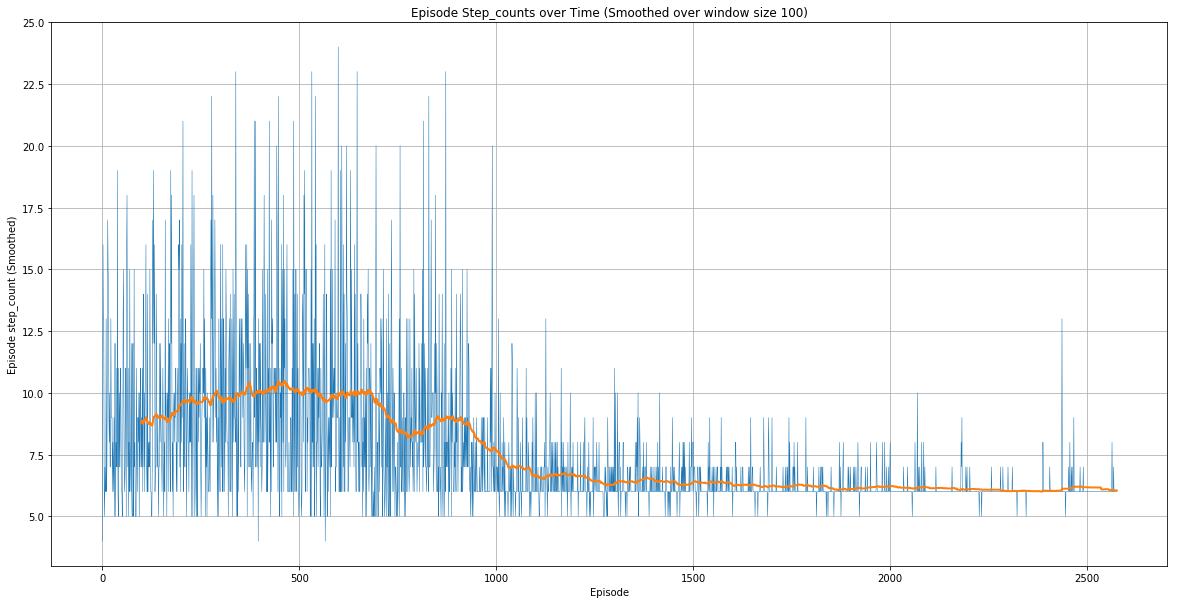

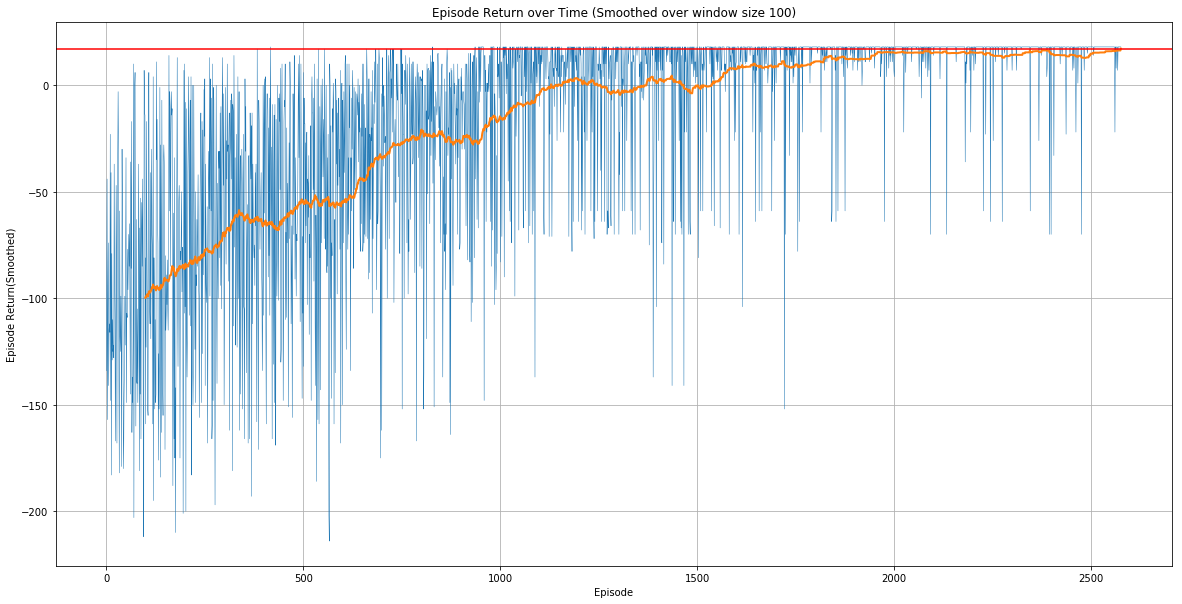

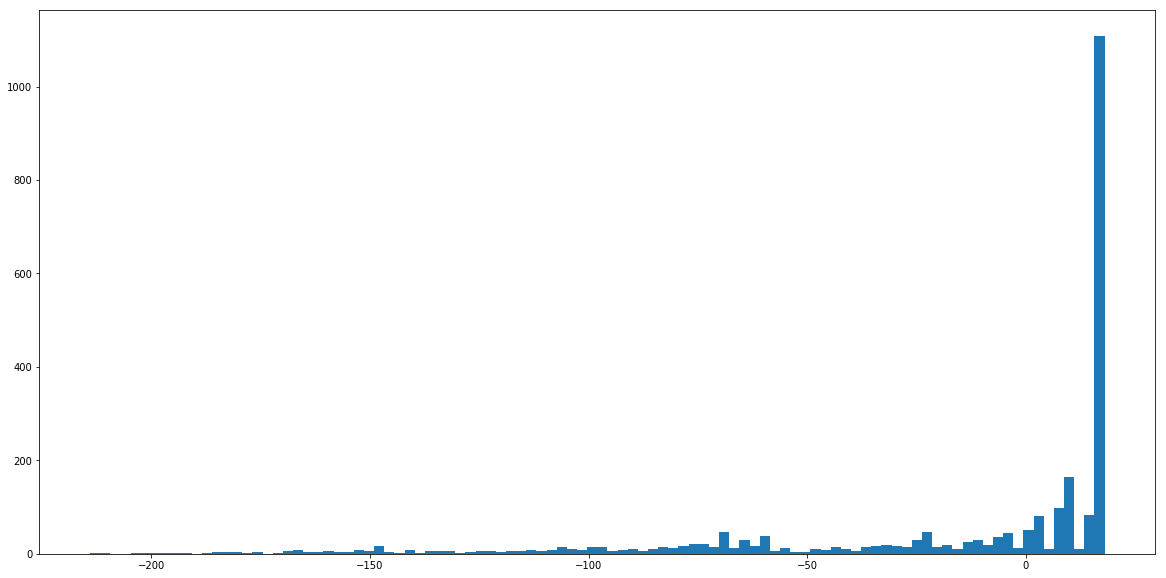

In [ ]:
if tune_hyper_parameter_train:

    learning_rate_list = [0.003, 0.01, 0.03, 0.1, 0.3, 1]

    gamma_learn_list = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
    episodes_num_toplateau_list = [300, 500, 800, 1000, 3000, 5000]
    eps_decay_list = [(eps_end_train / eps_start_learn) ** (1/nb) for nb in episodes_num_toplateau_list]

    for i, param in enumerate(eps_decay_list):
        # initialize/ reset the model
        vehicle_agent.reset_q_table()  
        folder_name_training = str(i) + '/'
        logger_name = str(i) + '.log'
        logger = Logger(folder_name_training, logger_name, 0)

        hyper_parameters = (
            method_used,
            gamma_learn,
            learning_rate_learn,
            eps_start_learn,
            eps_end_train,
            param  
        )
        logger.log(str(hyper_parameters), 1)

        returns_list_res, steps_counter_list_res = [], []
        dict_info_train = {}

        train_agent(flag_tkinter, vehicle_agent, *hyper_parameters,
                    window_success_res, threshold_success_train, returns_list_res,
                    steps_counter_list_res, dict_info_train,
                    episodes_num_max_train, steps_num_max_train, interval_sleep_train,
                    folder_name_training)
        logger.log(dict_info_train, 1)

        try:
            display_results(vehicle_agent, method_used, returns_list_res, window_success_res,
                            threshold_success_train, steps_counter_list_res,
                            display_flag=False, folder_name=folder_name_training)
        except Exception as e:
            print('Exception = {}'.format(e))

        # testing
        returns_list_testing = []  # passed as a reference
        test_agent(flag_tkinter, vehicle_agent, returns_list_testing, tests_num, steps_num_max_test,
                    interval_sleep_train, folder_name_training + "q_table.pkl")
        logger.log(returns_list_testing, 1)

if is_train:
    hyper_parameters = (
        method_used,
        gamma_learn,
        learning_rate_learn,
        eps_start_learn,
        eps_end_train,
        eps_decay_train
    )
    print("Hyper Parameters = {}".format(hyper_parameters))
    returns_list_res, steps_counter_list_res = [], []
    if flag_tkinter:
        env.after(100, train_agent, flag_tkinter, vehicle_agent,
                    *hyper_parameters,
                    window_success_res, threshold_success_train, returns_list_res,
                    steps_counter_list_res, dict_info_train,
                    episodes_num_max_train, steps_num_max_train, interval_sleep_train)
        env.mainloop()
        print("returns_list_res = {}, window_success_res = {}, steps_counter_list_res = {}".format(
            returns_list_res, window_success_res, steps_counter_list_res))
    else:
        train_agent(flag_tkinter, vehicle_agent, *hyper_parameters,
                    window_success_res, threshold_success_train, returns_list_res,
                    steps_counter_list_res, dict_info_train,
                    episodes_num_max_train, steps_num_max_train, interval_sleep_train)
    try:
        display_results(vehicle_agent, method_used, returns_list_res, window_success_res,
                        threshold_success_train, steps_counter_list_res,
                        display_flag=display_learn_results)
    except Exception as e:
        print('Exception = {}'.format(e))
    print("Hyper Parameters = {}".format(hyper_parameters))

    
if is_test:
    returns_list_testing = []
    if flag_tkinter:
        env.after(100, test_agent, flag_tkinter, vehicle_agent, returns_list_testing, tests_num, steps_num_max_test,
                    interval_sleep)
        env.mainloop()
    else:
        test_agent(flag_tkinter, vehicle_agent, returns_list_testing, tests_num, steps_num_max_test,
                    interval_sleep)

### Reference
1. https://mofanpy.com/tutorials/machine-learning/reinforcement-learning
2. https://towardsdatascience.com/reinforcement-learning-demystified-solving-mdps-with-dynamic-programming-b52c8093c919
3. http://www.incompleteideas.net/book/RLbook2020.pdf
4. https://arxiv.org/pdf/1704.02532.pdf
5. https://ieeexplore.ieee.org/abstract/document/8248668
6. https://github.com/openai/gym
7. https://towardsdatascience.com/reinforcement-learning-dynamic-programming-2b89da6ea1b
